STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath,index_col='Date')
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환 : 분산을 줄여줄 수도 있다.

In [50]:
# 결측치 처리
print(ts[ts.isna()])
ts = ts.interpolate(method='time')
print(ts[ts.isna()])  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)


- 결측치는 없었다.

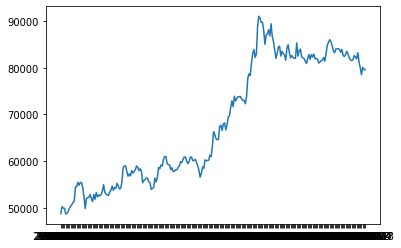

In [51]:
plt.plot(ts)

In [52]:
# 로그 변환 시도 
ts_log = np.log(ts)
ts_log.head()

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
Name: Close, dtype: float64

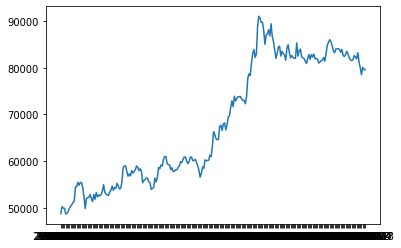

In [53]:
plt.plot(ts)

큰변화 x

STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [54]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    orig, = ax1.plot(timeseries, color='blue',label='Original')    
    mean, = ax1.plot(rolmean, color='red', label='Rolling Mean')
    std, = ax2.plot(rolstd, color='green', label='Rolling Std')
    label = [orig, mean]
    ax1.legend(label, [i.get_label() for i in label], loc=2)
    ax2.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #우수노드 참고
    #축을 2개로해서 rolling mean과 original을 분리시켰다.

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    


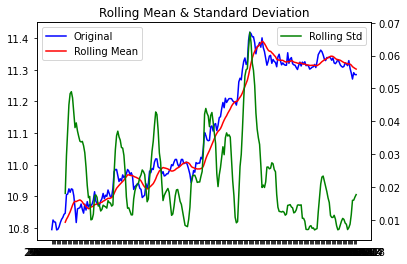

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


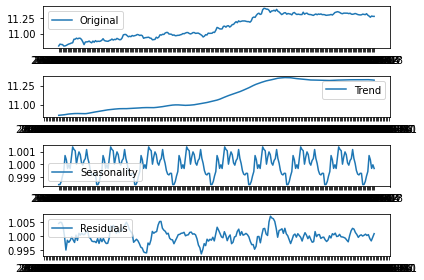

In [55]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12) # 1년 

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log) 

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [56]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


>p-value의 정의 : 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로서, 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 하다. 이 값이 0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

- p-value = 0.590149
- 귀무가설을 기각하고 대립가설을 채택하기 어렵다.

>Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다. 뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

#### residual은 낮아 일단 데이터가 Stationary한 데이터인것은 확인 

residual은 낮아 일단 데이터가 Stationary한 데이터인것은 확인하였지만 직접 눈으로 확인을 해보자  
- Moving average 제거 - 추세(Trend) 상쇄하기 (12일단위)

In [57]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)


Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

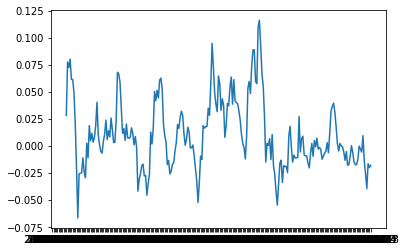

In [58]:
plt.plot(ts_log_moving_avg)

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

In [59]:
augmented_dickey_fuller_test(ts_log_moving_avg) 

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


- 12일 단위로 경향성을 잘라보니 p-value가 눈에 띄게 줄었다.
- 귀무가설을 기각하고 대립가설을 세워 이 데이터가 Stationary


STEP 4 : 학습, 테스트 데이터셋 생성

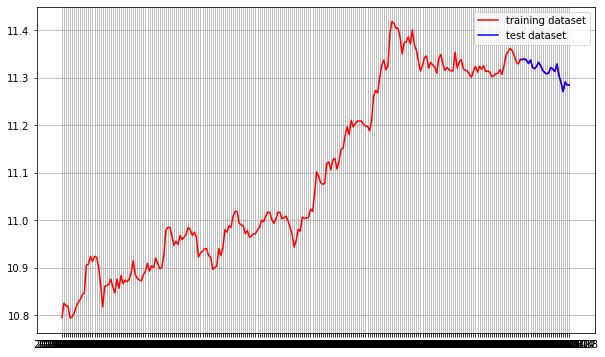

In [60]:
# 최근날짜 기준으로 10%를 테스트 셋으로

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


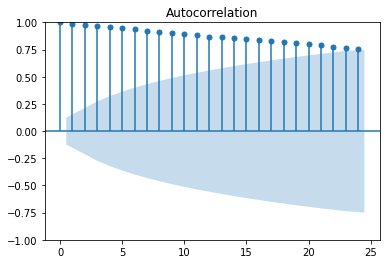

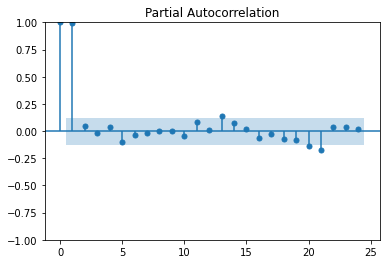

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


- ACF를 보니 규칙적으로 보인다. => Stationary하지 않다는 것을 알 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


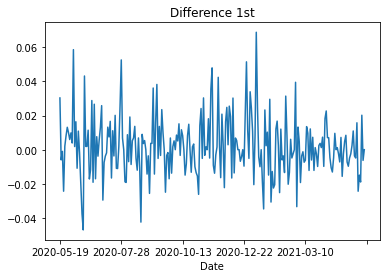

In [62]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


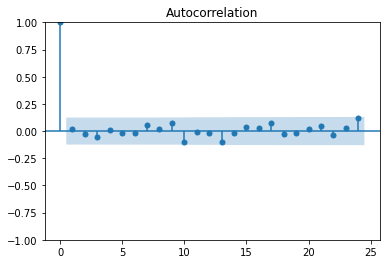

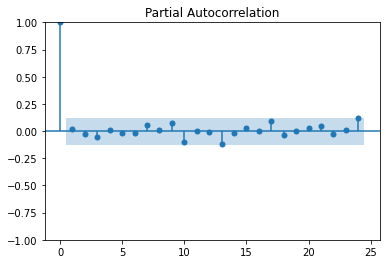

In [63]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p-value가 더욱 낮아졌다. 그래프만 보아도 화이트노이즈에 가깝게 된듯하다.
- ACF는 불규칙적으로 변하였다 => 데이터가 Stationary하게 되었다.
- d는 1로도 충분하다 판단

![](Identify_Arima.PNG)
![](https://d3s0tskafalll9.cloudfront.net/media/images/E-16-4.max-800x600.png)
- 데이터 전처리는 끝났다. 
- 훈련을 시키기전 어떤 모델이 좋을지의 사전 모델을 생각
- 출처 https://www.youtube.com/watch?v=P_3808Xv76Q,  https://datascienceschool.net]
 >ACF와 PACF가 둘다 lag가 1일때 cut off되고 sign 함수를 띈다.  
 p와 q 모두 1을 주면 좋겠다고 판단함


In [64]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1)) # p d q   
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 583.489
Date:                Thu, 17 Feb 2022   AIC                          -1160.979
Time:                        10:49:16   BIC                          -1150.744
Sample:                             0   HQIC                         -1156.847
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      2.094      0.006      0.995      -4.092       4.117
ma.L1          0.0237      2.102      0.011      0.991      -4.096       4.143
sigma2         0.0003   2.47e-05     12.936      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


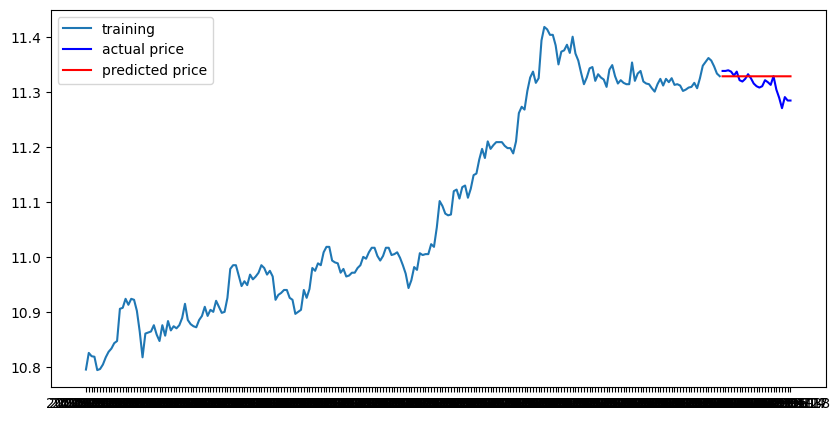

In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [66]:
# predict 값 확인 
fitted_m.predict()[:5]

Date
2020-05-18     0.000000
2020-05-19    10.795486
2020-05-20    10.826857
2020-05-21    10.819535
2020-05-22    10.818747
Name: predicted_mean, dtype: float64

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480580.457711579
MAE:  1403.0537770723201
RMSE:  1865.631383127862
MAPE: 1.74%


### apple 2017-01-01 ~ 2021-01-01
- 단위는 日

In [68]:
dataset_filepath = './AAPL.csv'
df = pd.read_csv(dataset_filepath,index_col='Date')
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2017-01-03    29.037500
2017-01-04    29.004999
2017-01-05    29.152500
2017-01-06    29.477501
2017-01-09    29.747499
Name: Close, dtype: float64

In [69]:
ts_log = np.log(ts)
ts_log.head()

Date
2017-01-03    3.368588
2017-01-04    3.367468
2017-01-05    3.372541
2017-01-06    3.383627
2017-01-09    3.392745
Name: Close, dtype: float64

In [70]:
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


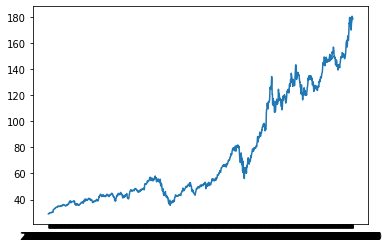

In [71]:
plt.plot(ts)

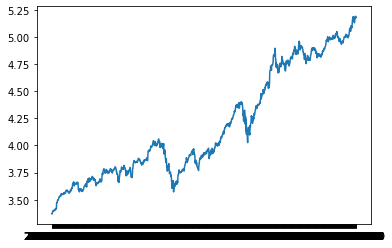

In [72]:
plt.plot(ts_log)

- log값을 취했을때 분산이 조금 줄어든 모습을 볼 수 있다.

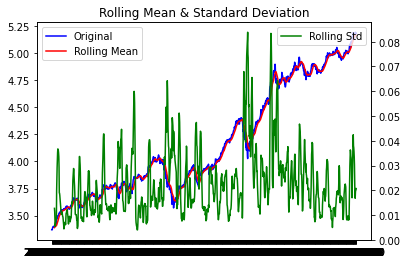

Results of Dickey-Fuller Test:
Test Statistic                   -0.040069
p-value                           0.955090
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


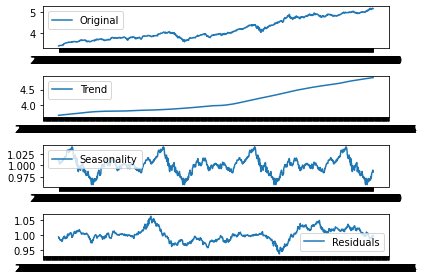

In [73]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12) # 1년 

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log) 

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 365)  # 365일로 period

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [74]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.585223
p-value                          0.006050
#Lags Used                      19.000000
Number of Observations Used    874.000000
Critical Value (1%)             -3.437854
Critical Value (5%)             -2.864853
Critical Value (10%)            -2.568534
dtype: float64


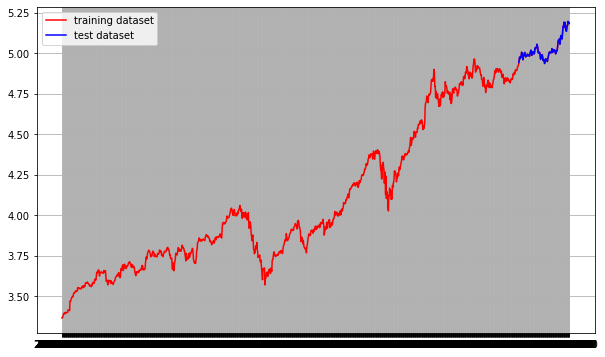

In [75]:
# 최근날짜 기준으로 10%를 테스트 셋으로

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


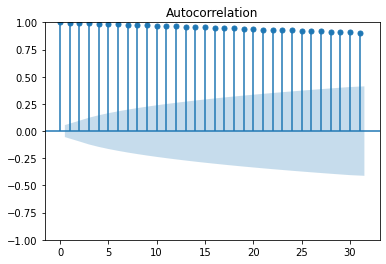

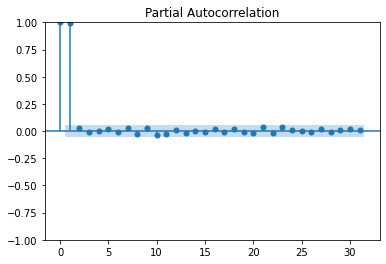

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.105320e+01
p-value                        5.019492e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


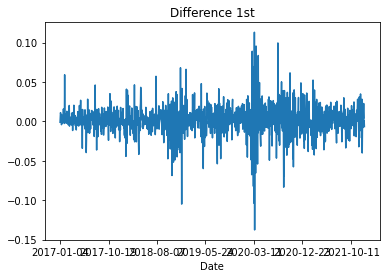

In [77]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


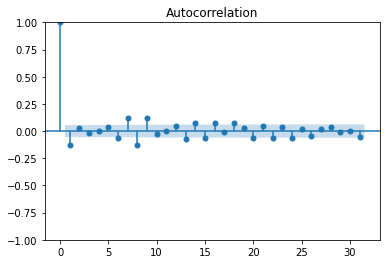

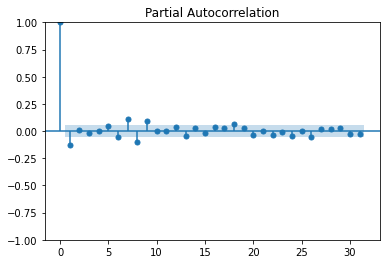

In [78]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [86]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1)) # p d q   
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1132
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2844.584
Date:                Thu, 17 Feb 2022   AIC                          -5683.168
Time:                        10:53:29   BIC                          -5668.076
Sample:                             0   HQIC                         -5677.466
                               - 1132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2859      0.122     -2.334      0.020      -0.526      -0.046
ma.L1          0.1560      0.128      1.215      0.224      -0.096       0.408
sigma2         0.0004   8.55e-06     44.768      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


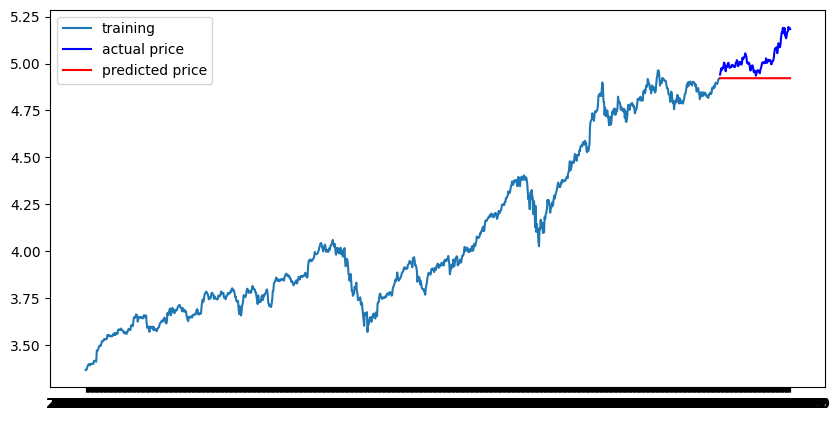

In [87]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [88]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  346.40725747685633
MAE:  15.30856894890643
RMSE:  18.612019167109633
MAPE: 9.64%


### samsung 2017-01-01 ~ 2021-01-01
- 단위는 日

In [89]:
dataset_filepath = './Samsung_KS.csv'
df = pd.read_csv(dataset_filepath,index_col='Date')
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2017-01-02    36100.0
2017-01-03    36480.0
2017-01-04    36160.0
2017-01-05    35560.0
2017-01-06    36200.0
Name: Close, dtype: float64

In [90]:
ts_log = np.log(ts)
ts_log.head()

Date
2017-01-02    10.494048
2017-01-03    10.504519
2017-01-04    10.495709
2017-01-05    10.478977
2017-01-06    10.496814
Name: Close, dtype: float64

In [91]:
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


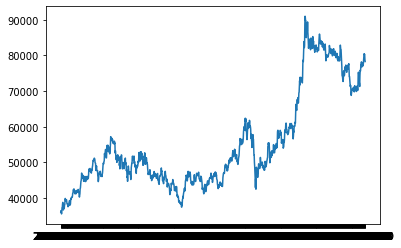

In [92]:
plt.plot(ts)

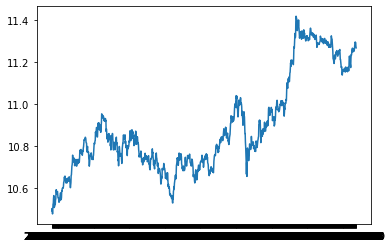

In [93]:
plt.plot(ts_log)

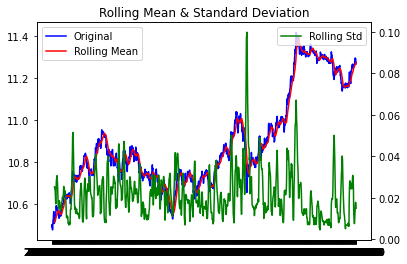

Results of Dickey-Fuller Test:
Test Statistic                   -1.327834
p-value                           0.616344
#Lags Used                        0.000000
Number of Observations Used    1226.000000
Critical Value (1%)              -3.435695
Critical Value (5%)              -2.863900
Critical Value (10%)             -2.568027
dtype: float64


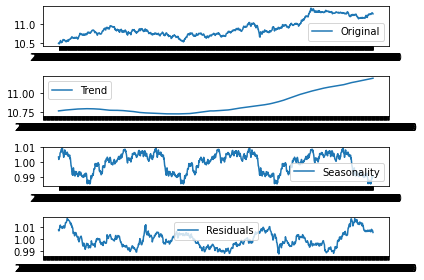

In [94]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12) # 1년 

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log) 

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 365)  # 365일로 period

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [95]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.648358
p-value                          0.004901
#Lags Used                      17.000000
Number of Observations Used    845.000000
Critical Value (1%)             -3.438112
Critical Value (5%)             -2.864966
Critical Value (10%)            -2.568595
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


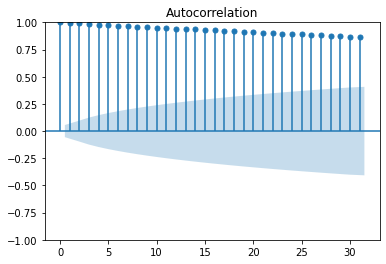

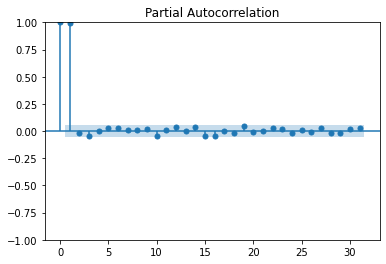

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -34.271137
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1225.000000
Critical Value (1%)              -3.435699
Critical Value (5%)              -2.863902
Critical Value (10%)             -2.568028
dtype: float64


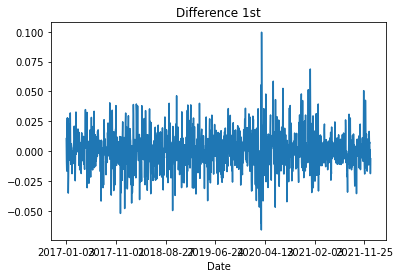

In [97]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


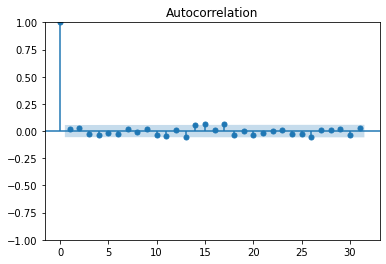

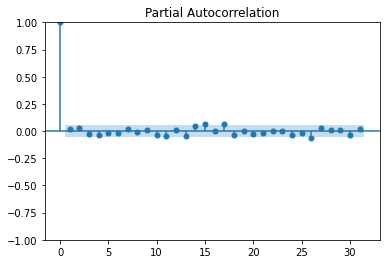

In [98]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [99]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(5, 1, 5)) # p d q   
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1132
Model:                 ARIMA(5, 1, 5)   Log Likelihood                2851.147
Date:                Thu, 17 Feb 2022   AIC                          -5680.294
Time:                        11:08:17   BIC                          -5624.954
Sample:                             0   HQIC                         -5659.387
                               - 1132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2667      1.012     -0.264      0.792      -2.250       1.716
ar.L2          0.2058      0.850      0.242      0.809      -1.460       1.871
ar.L3          0.2630      0.381      0.690      0.4

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


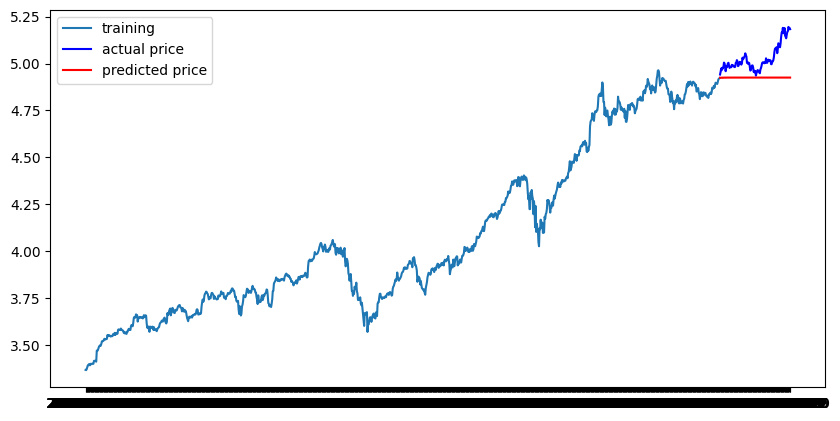

In [100]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [101]:

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  332.5226354374856
MAE:  14.853154018344034
RMSE:  18.235203191560153
MAPE: 9.34%


- mape 기준은 모두 달성했다.

# 회고
- 모델자체가 통계학에 대한 지식이 기반되어있어야 해서 힘들었다.
- predict가 잘되지 않아 아쉬웠다. 

